In [2]:
pip install pgmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import DiscreteBayesianNetwork as BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import os



In [10]:
# Step 1: Load the dataset
df = pd.read_csv('heart_disease.csv')

In [15]:
# Step 2: Data Cleaning
df = df.drop_duplicates()
df = df.dropna()

# Normalize numeric columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numerical_cols] = (df[numerical_cols] - df[numerical_cols].min()) / (df[numerical_cols].max() - df[numerical_cols].min())

# Discretize into 3 bins (Low, Medium, High)
for col in numerical_cols:
    df[col] = pd.cut(df[col], bins=3, labels=["low", "medium", "high"])


# Step 4: Save cleaned dataset
df.to_csv("heart_disease_cleaned.csv", index=False)

In [16]:
# Step 5: Define Bayesian Network structure
model = BayesianModel([
    ('age', 'fbs'),
    ('fbs', 'target'),
    ('target', 'chol'),
    ('target', 'thalach')
])

In [17]:
# Step 6: Train using Maximum Likelihood Estimation
model.fit(df, estimator=MaximumLikelihoodEstimator)

# Step 7: Inference
infer = VariableElimination(model)

In [18]:
# Example 1: Probability of heart disease (target) given high age
q1 = infer.query(variables=['target'], evidence={'age': 'high'})
print("\nP(target | age = 'high'):\n", q1)

# Example 2: Cholesterol distribution given heart disease is present
q2 = infer.query(variables=['chol'], evidence={'target': 'high'})
print("\nP(chol | target = 'high'):\n", q2)

# Example 3: Max heart rate distribution given no heart disease
q3 = infer.query(variables=['thalach'], evidence={'target': 'low'})
print("\nP(thalach | target = 'low'):\n", q3)




P(target | age = 'high'):
 +--------------+---------------+
| target       |   phi(target) |
+==============+===============+
| target(high) |        0.5423 |
+--------------+---------------+
| target(low)  |        0.4577 |
+--------------+---------------+

P(chol | target = 'high'):
 +--------------+-------------+
| chol         |   phi(chol) |
+==============+=============+
| chol(high)   |      0.0061 |
+--------------+-------------+
| chol(low)    |      0.7927 |
+--------------+-------------+
| chol(medium) |      0.2012 |
+--------------+-------------+

P(thalach | target = 'low'):
 +-----------------+----------------+
| thalach         |   phi(thalach) |
+=================+================+
| thalach(high)   |         0.2174 |
+-----------------+----------------+
| thalach(low)    |         0.1667 |
+-----------------+----------------+
| thalach(medium) |         0.6159 |
+-----------------+----------------+


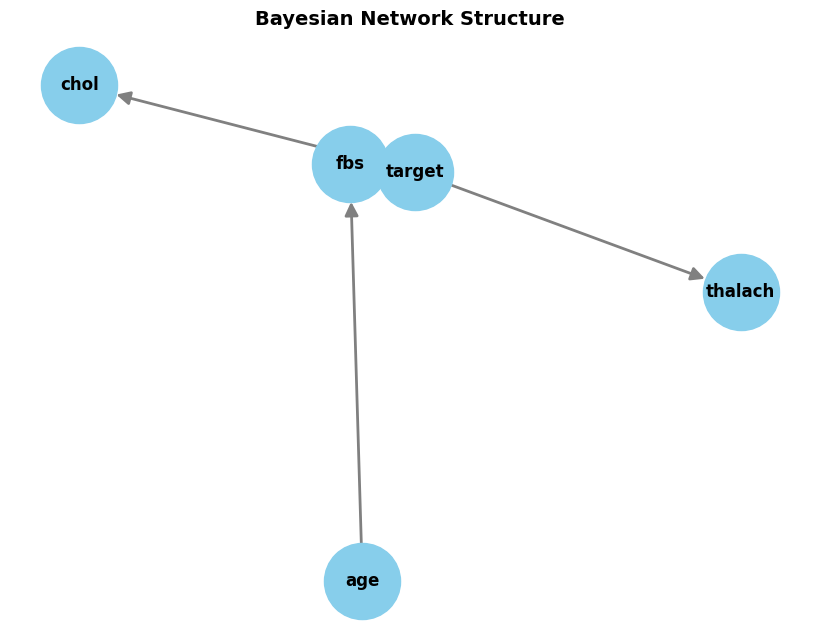

In [21]:
# Step 8: Visualize the Bayesian Network safely
import matplotlib.pyplot as plt
import networkx as nx

# Create a plain NetworkX DiGraph from pgmpy's model structure
G = nx.DiGraph()
G.add_edges_from(model.edges())

# Draw the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)  # fixed seed for consistent layout
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color='skyblue',
    node_size=3000,
    edge_color='gray',
    font_size=12,
    font_weight='bold',
    arrows=True,
    arrowsize=20,
    width=2
)
plt.title("Bayesian Network Structure", fontsize=14, fontweight='bold')
os.makedirs("images", exist_ok=True)
plt.savefig("images/bayesian_network.png", bbox_inches='tight')
plt.show()


